# NER : Classification de tokens

# Problématique

L'objectif de notre projet en traitement du langage naturel (NLP) est d'identifier les entités telles que les personnes, les lieux ou les organisations dans une phrase. Cela implique d'attribuer une étiquette à chaque token faisant partie d'une entité, avec une classe spécifique pour chaque type d'entité et une classe pour les tokens qui ne font pas partie d'une entité. 
Cette tâche de Reconnaissance d'Entités Nommées (NER) peut être utile pour d'autres applications en NLP, telles que déterminer le type de réponse que le système de Questions-Réponses doit fournir en se basant sur les entités identifiées dans la question (par exemple, un lieu, une date), ou pour les chatbots, etc .. 

### Libraries

In [ ]:
! pip install datasets evaluate transformers[sentencepiece] accelerate seqeval
! pip install accelerate
! pip install evaluate

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorForTokenClassification, AutoModelForTokenClassification, get_scheduler, pipeline
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from accelerate import Accelerator
import evaluate
from tqdm.auto import tqdm

# Importation des données 

Nous avons ici utilisé un ensemble de données adapté à la classification de token : CoNLL-2003, qui contient des actualités de Reuters.
Il s'agit d'un jeu de donnée avec des textes pré-tokenisées qui doivent encore passer par le tokenizer pour la tokenisation des sous-mots en mots comme on peu le voir ci dessous dans la colonne tokens sous forme de listes de mots. L'ensemble de données contient des étiquettes pour les trois tâches : NER, POS et chunking. Mais nous allons uniquement utilisé les colonnes tokens et ner_tags pour notre objectif.
Chaque observation représente une phrasé pré tokeniser (liste de mots) et la colonne ner_tags contient les labels associé à nos token qui peuvent etre soit :

- O : qui signifie que le mot ne correspond à aucune entité.
- B-PER/ I-PER : qui signifie que le mot correspond au début de (B) /est à l'intérieur d'une entité personne(I).
- B-ORG/ I-ORG : signifie que le mot correspond au début de/est à l'intérieur d'une entité organisationnelle.
- B-LOC/ I-LOC : signifie que le mot correspond au début de/est à l'intérieur d'une entité de localisation.
- B-MISC/ I-MISC : signifie que le mot correspond au début de/est à l'intérieur d'une entité diverse 


In [3]:
# Chargement du dataset CoNLL 2003
raw_datasets = load_dataset("conll2003")

In [58]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [12]:
raw_datasets["train"].select(range(3))

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 3
})

In [60]:
raw_datasets["train"][:3]

{'id': ['0', '1', '2'],
 'tokens': [['EU',
   'rejects',
   'German',
   'call',
   'to',
   'boycott',
   'British',
   'lamb',
   '.'],
  ['Peter', 'Blackburn'],
  ['BRUSSELS', '1996-08-22']],
 'pos_tags': [[22, 42, 16, 21, 35, 37, 16, 21, 7], [22, 22], [22, 11]],
 'chunk_tags': [[11, 21, 11, 12, 21, 22, 11, 12, 0], [11, 12], [11, 12]],
 'ner_tags': [[3, 0, 7, 0, 0, 0, 7, 0, 0], [1, 2], [5, 0]]}

In [16]:
label_names = ner_feature.feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

# EDA

Notre ensemble de données est divisé en 3 échantillons dans le but d'évaluer les performances prédictives du modèle, notamment sa robustesse face au surapprentissage. Nous disposons d'un échantillon d'entraînement avec 14,041 observations sur lequel nous allons entraîner notre modèle, un échantillon de test avec 3,453 données, et un échantillon de validation avec 3,250 données.
En premier lieu, une brève analyse exploratoire préliminaire du jeu de données a été effectuée pour mieux comprendre notre ensemble de données.

### Visualisation du nombre de phrases et nombre de token par phrases pour chacun des ensembles

In [4]:
# Calcul du nombre de lignes pour chaque ensemble
num_train_examples = len(raw_datasets["train"])
num_test_examples = len(raw_datasets["test"])
num_val_examples = len(raw_datasets["validation"])

print("Nombre de lignes pour chaque ensemble :")
print("Entraînement :", num_train_examples)
print("Test :", num_test_examples)
print("Validation :", num_val_examples)


Nombre de lignes pour chaque ensemble :
Entraînement : 14041
Test : 3453
Validation : 3250


In [10]:
# Fonction pour calculer les longueurs des tokens
def get_token_lengths(token_lists):
    token_lengths = [len(tokens) for tokens in token_lists]
    return token_lengths

# Calcul des longueurs des tokens pour chaque ensemble
train_token_lengths = get_token_lengths(raw_datasets["train"]["tokens"])
test_token_lengths = get_token_lengths(raw_datasets["test"]["tokens"])
val_token_lengths = get_token_lengths(raw_datasets["validation"]["tokens"])

# Calcul du nombre moyen de tokens par phrase pour chaque ensemble
train_avg_tokens = sum(train_token_lengths) / len(train_token_lengths)
test_avg_tokens = sum(test_token_lengths) / len(test_token_lengths)
val_avg_tokens = sum(val_token_lengths) / len(val_token_lengths)

# Affichage des résultats
print("Nombre moyen de tokens par phrase :")
print("Entraînement :", train_avg_tokens)
print("Test :", test_avg_tokens)
print("Validation :", val_avg_tokens)

Nombre moyen de tokens par phrase :
Entraînement : 14.501887329962253
Test : 13.447726614538082
Validation : 15.803692307692307


Résumé statistique du nombre de tokens par ligne :
               Train         Test   Validation
count  14041.000000  3453.000000  3250.000000
mean      14.501887    13.447727    15.803692
std       11.602756    11.552513    12.603389
min        1.000000     1.000000     1.000000
25%        6.000000     5.000000     7.000000
50%       10.000000     9.000000    11.000000
75%       22.000000    20.000000    24.000000
max      113.000000   124.000000   109.000000


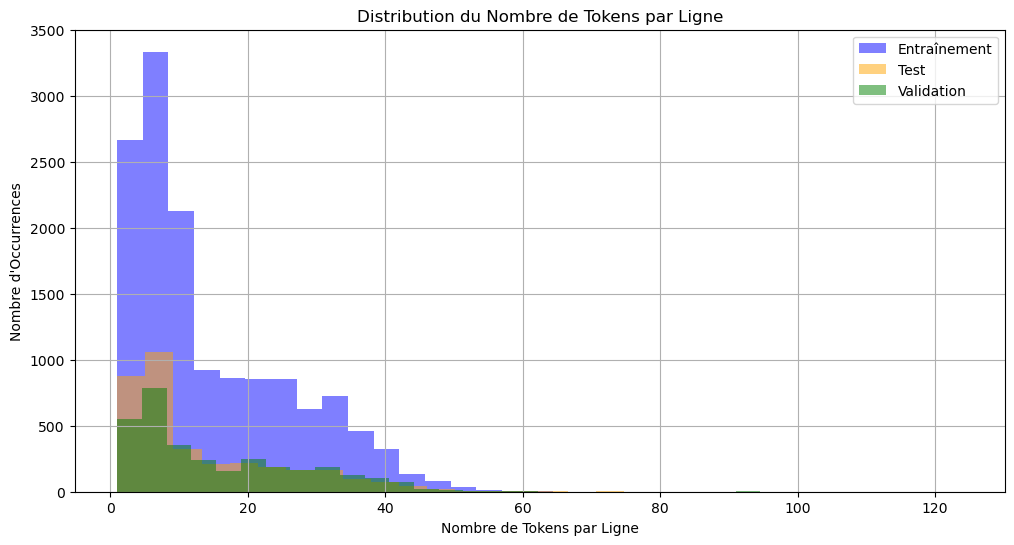

In [22]:

# Création des DataFrames pour chaque ensemble
train_df = pd.DataFrame(train_token_lengths, columns=['Train'])
test_df = pd.DataFrame(test_token_lengths, columns=['Test'])
val_df = pd.DataFrame(val_token_lengths, columns=['Validation'])

# Concaténation des DataFrames
all_df = pd.concat([train_df, test_df, val_df], axis=1)

# Résumé statistique (describe)
describe = all_df.describe()

# Affichage du describe
print("Résumé statistique du nombre de tokens par ligne :\n", describe)

# Création des histogrammes
plt.figure(figsize=(12, 6))
plt.hist(train_token_lengths, bins=30, alpha=0.5, label='Entraînement', color='blue')
plt.hist(test_token_lengths, bins=30, alpha=0.5, label='Test', color='orange')
plt.hist(val_token_lengths, bins=30, alpha=0.5, label='Validation', color='green')

# Ajout de titres et de légendes
plt.xlabel('Nombre de Tokens par Ligne')
plt.ylabel('Nombre d\'Occurrences')
plt.title('Distribution du Nombre de Tokens par Ligne')
plt.legend()

# Affichage du graphique
plt.grid(True)
plt.show()

###  Visualisation de la frquence de chaque label et déséquilibres

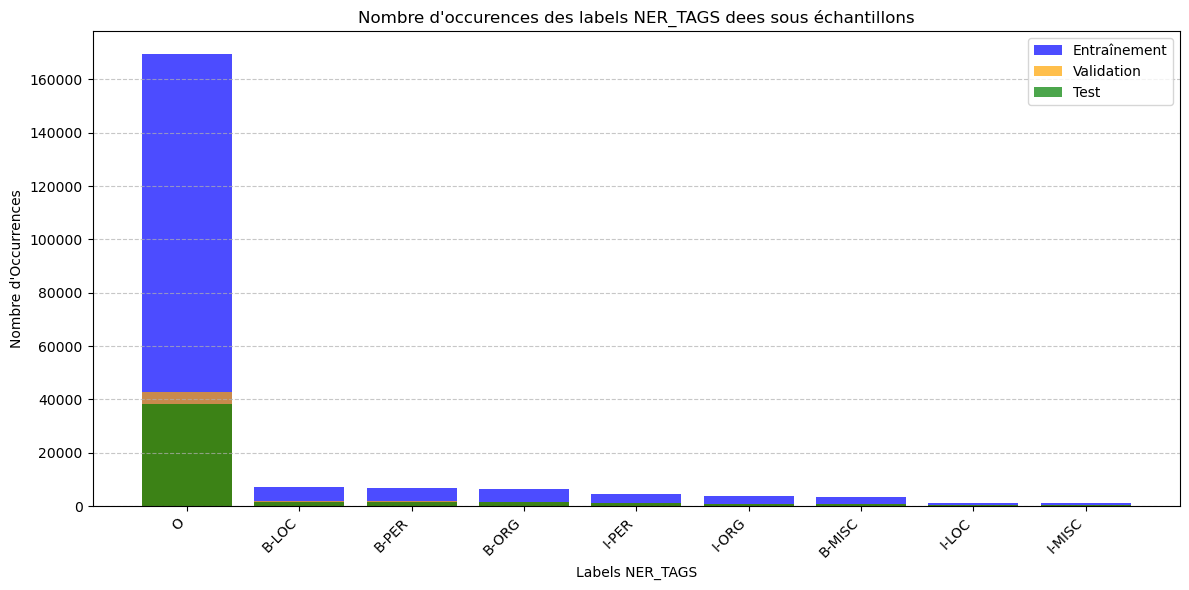

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Les noms réels des labels NER
label_names = [
    "O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-MISC", "I-MISC"
]

# Création de DataFrames pour chaque ensemble
train_df = pd.DataFrame(raw_datasets["train"])
val_df = pd.DataFrame(raw_datasets["validation"])
test_df = pd.DataFrame(raw_datasets["test"])

# Explosion des tags NER et calcul du value count pour chaque ensemble
train_ner_counts = train_df["ner_tags"].explode().value_counts()
val_ner_counts = val_df["ner_tags"].explode().value_counts()
test_ner_counts = test_df["ner_tags"].explode().value_counts()

# Renommer les index avec les vrais noms des labels
train_ner_counts_with_names = train_ner_counts.rename(index={i: label_names[i] for i in range(len(label_names))})
val_ner_counts_with_names = val_ner_counts.rename(index={i: label_names[i] for i in range(len(label_names))})
test_ner_counts_with_names = test_ner_counts.rename(index={i: label_names[i] for i in range(len(label_names))})

# Création du graphique
plt.figure(figsize=(12, 6))
plt.bar(train_ner_counts_with_names.index, train_ner_counts_with_names, alpha=0.7, label='Entraînement', color='blue')
plt.bar(val_ner_counts_with_names.index, val_ner_counts_with_names, alpha=0.7, label='Validation', color='orange')
plt.bar(test_ner_counts_with_names.index, test_ner_counts_with_names, alpha=0.7, label='Test', color='green')

# Ajout de titres et de légendes
plt.xlabel('Labels NER_TAGS')
plt.ylabel('Nombre d\'Occurrences')
plt.title('Nombre d\'occurences des labels NER_TAGS dees sous échantillons')
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes x pour une meilleure lisibilité
plt.legend()

# Affichage du graphique
plt.tight_layout()  # Ajustement automatique pour éviter les chevauchements
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


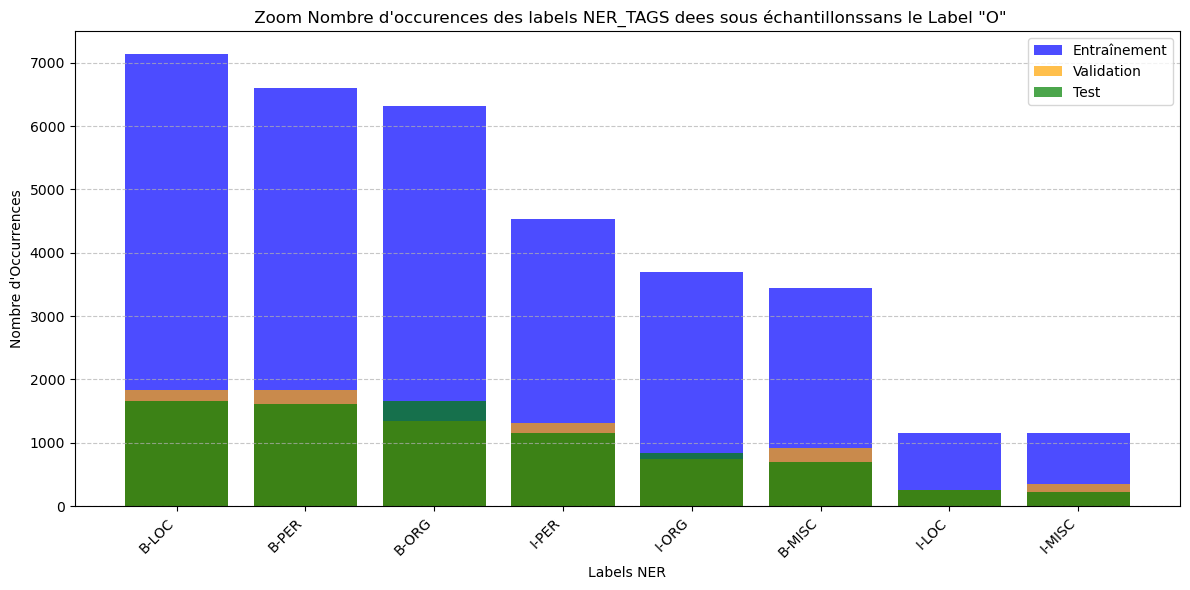

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Les noms réels des labels NER (sans le label "O")
label_names = [
    "O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-MISC", "I-MISC"
]

# Création de DataFrames pour chaque ensemble
train_df = pd.DataFrame(raw_datasets["train"])
val_df = pd.DataFrame(raw_datasets["validation"])
test_df = pd.DataFrame(raw_datasets["test"])

# Explosion des tags NER et calcul du value count pour chaque ensemble
train_ner_counts = train_df["ner_tags"].explode().value_counts()
val_ner_counts = val_df["ner_tags"].explode().value_counts()
test_ner_counts = test_df["ner_tags"].explode().value_counts()

# Exclure la première valeur (index 0) des counts et renommer les index avec les vrais noms des labels
train_ner_counts_with_names = train_ner_counts.drop(0).rename(index={i: label_names[i] for i in range(1, len(label_names))})
val_ner_counts_with_names = val_ner_counts.drop(0).rename(index={i: label_names[i] for i in range(1, len(label_names))})
test_ner_counts_with_names = test_ner_counts.drop(0).rename(index={i: label_names[i] for i in range(1, len(label_names))})

# Création du graphique
plt.figure(figsize=(12, 6))
plt.bar(train_ner_counts_with_names.index, train_ner_counts_with_names, alpha=0.7, label='Entraînement', color='blue')
plt.bar(val_ner_counts_with_names.index, val_ner_counts_with_names, alpha=0.7, label='Validation', color='orange')
plt.bar(test_ner_counts_with_names.index, test_ner_counts_with_names, alpha=0.7, label='Test', color='green')

# Ajout de titres et de légendes
plt.xlabel('Labels NER')
plt.ylabel('Nombre d\'Occurrences')
plt.title(' Zoom Nombre d\'occurences des labels NER_TAGS dees sous échantillonssans le Label "O"')
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes x pour une meilleure lisibilité
plt.legend()

# Affichage du graphique
plt.tight_layout()  # Ajustement automatique pour éviter les chevauchements
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Visualisation du nombre de caracteres moyen des tokens par labels

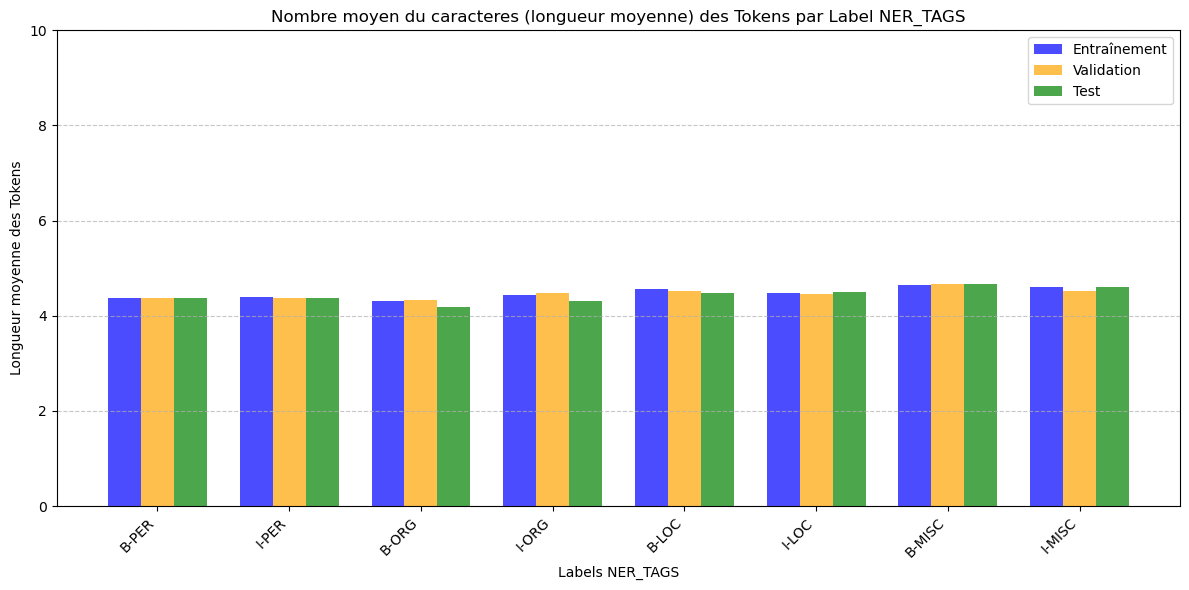

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Les noms réels des labels NER (sans le label "O")
label_names = [
    "O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-MISC", "I-MISC"
]

# Création de DataFrames pour chaque ensemble
train_df = pd.DataFrame(raw_datasets["train"])
val_df = pd.DataFrame(raw_datasets["validation"])
test_df = pd.DataFrame(raw_datasets["test"])

# Fonction pour calculer la longueur moyenne des tokens par label NER
def avg_token_length_per_label(df):
    token_lengths_per_label = []
    for label in range(1, len(label_names)):
        tokens_per_label = df[df['ner_tags'].apply(lambda x: label in x)]['tokens']
        token_lengths = tokens_per_label.explode().apply(len)
        avg_token_length = token_lengths.mean()
        token_lengths_per_label.append(avg_token_length)
    return token_lengths_per_label

# Calcul de la longueur moyenne des tokens par label pour chaque ensemble
train_avg_lengths = avg_token_length_per_label(train_df)
val_avg_lengths = avg_token_length_per_label(val_df)
test_avg_lengths = avg_token_length_per_label(test_df)

# Création du graphique
plt.figure(figsize=(12, 6))

# Largeur des barres
bar_width = 0.25

# Positions des barres sur l'axe x
r1 = range(len(label_names[1:]))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Barres pour l'ensemble d'entraînement
plt.bar(r1, train_avg_lengths, width=bar_width, alpha=0.7, label='Entraînement', color='blue')
# Barres pour l'ensemble de validation
plt.bar(r2, val_avg_lengths, width=bar_width, alpha=0.7, label='Validation', color='orange')
# Barres pour l'ensemble de test
plt.bar(r3, test_avg_lengths, width=bar_width, alpha=0.7, label='Test', color='green')

# Ajout des étiquettes sur l'axe x
plt.xlabel('Labels NER_TAGS')
plt.ylabel('Longueur moyenne des Tokens')
plt.title('Nombre moyen du caracteres (longueur moyenne) des Tokens par Label NER_TAGS')
plt.xticks([r + bar_width for r in range(len(label_names[1:]))], label_names[1:], rotation=45, ha='right')

# Limite de l'axe y
plt.ylim(0, 10)

# Ajout de la légende
plt.legend()

# Affichage du graphique
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



Résumé de notre analyse exploratoire :

Le nombre moyen de mots par phrase semble être similaire dans chaque ensemble, avec une moyenne de 14 mots par phrase. De plus, la distribution du nombre de mots par phrase est homogène dans tous les ensembles. Les fréquences des labels révèlent un déséquilibre naturel, en particulier dans la catégorie 0 qui regroupe les autres tokens, mais cette répartition est similaire entre les ensembles.  Toutefois, l'ensemble de validation ne comporte pas d'entités nommées (NER) pour l'organisation.
Les différentes catégories NER présentent une longueur moyenne en caractère similaire entre elles et sur les trois ensembles, avec environ 5 caractères en moyenne. 
En considérant la visualisation des fréquences de caractères et de tokens par label, nous pouvons constaté avec évidence que le modèle TF-IDF basé sur des statistiques de fréquences est encore moins adapté à la classification de tokens que la classification de phrases, manquant de features pertinentes pour cette tache. 
Ainsi il est nécessaire d'utiliser des modèles de vectorisation de tokens afin d'exploiter le contexte et la signification des mots pour notre tâche.
Enfin les modèles téstés seront spécifique à l'anglais, étant donné que c'est la seule langue utilisée dans les phrases analysées.


# Explication du Preprocessing sur les données tokeniseer en subword (sous mots)

Si les modèles de vectorisation tels que BERT ne nécessitent pas de nettoyage de données particulier avant la tokenisation, comme la suppression des stopwords, la stemmatisation, ou la lemmatisation nécessaires pour les modèles plus traditionnels par exemple, ils nécessitent d'autres transformations après la tokenisation lorsqu'il s'agit d'une tâche de NER (Reconnaissance d'Entités Nommées) pour pallier à des problèmes de dimensions, que nous allons expliquer.

Tout d'abord, voici un exemple : la première phrase de l'ensemble d'entraînement (colonne token). La phrase est pré-tokenisée, c'est-à-dire divisée en tokens dans le jeu de données avec 9 tokens : ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']. Nous avons donc également 9 labels NER associés à ces 9 tokens (ner_tags) qui nous indiquent le type de chacun des mots respectifs : [B-ORG, O, B-MISC, O, O, O, B-MISC, O, O]

In [26]:
raw_datasets["train"][0]["tokens"]
#

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

In [27]:
words = raw_datasets["train"][0]["tokens"]
labels = raw_datasets["train"][0]["ner_tags"]
line1 = "" 
line2 = ""
for word, label in zip(words, labels):
    full_label = label_names[label]
    max_length = max(len(word), len(full_label))
    line1 += word + " " * (max_length - len(word) + 1)
    line2 += full_label + " " * (max_length - len(full_label) + 1)

print(line1)
print(line2)

EU    rejects German call to boycott British lamb . 
B-ORG O       B-MISC O    O  O       B-MISC  O    O 


Comme évoqué précédemment, les entités couvrant deux mots comme "Union européenne" ont des labels attribués avec "B" au premier mot et "I" au second : Ainsi, de la même manière lors de la tokenisation, les mots qui seront découpés en plusieurs sous-mots pour que le modèle de vectorisation puisse les reconnaître dans le vocabulaire vont poser des problèmes de dimensions, car le nombre de labels associés aux tokens n'aura lui pas changé si nous n'effectuons pas de prétraitement, c'est-à-dire qu'il y aura plus de tokens que de labels ner-tags. De plus, avec l'ajout de tokens spéciaux (index None), notamment pour les transformers, le nombre de tokens augmente davantage et ne correspond plus au nombre de labels. Il faut donc relabeliser nos étiquettes en fonction de ces changements, c'est l'objectif de notre fonction de prétraitement.

In [28]:
words = raw_datasets["train"][3]["tokens"]
labels = raw_datasets["train"][3]["ner_tags"]
line1 = "" 
line2 = ""
for word, label in zip(words, labels):
    full_label = label_names[label]
    max_length = max(len(word), len(full_label))
    line1 += word + " " * (max_length - len(word) + 1)
    line2 += full_label + " " * (max_length - len(full_label) + 1)

print(line1)
print(line2)

The European Commission said on Thursday it disagreed with German advice to consumers to shun British lamb until scientists determine whether mad cow disease can be transmitted to sheep . 
O   B-ORG    I-ORG      O    O  O        O  O         O    B-MISC O      O  O         O  O    B-MISC  O    O     O          O         O       O   O   O       O   O  O           O  O     O 


# Preprocessing :


Comme on peut le voir ici, les tokens spéciaux ont été ajoutés : CLS et SEP (input_id : None), et le mot "lamb" a été divisé en deux sous-mots, ce qui introduit une inadéquation entre nos entrées et les étiquettes : la liste des étiquettes ne comporte que 9 éléments, alors que notre entrée comporte désormais 12 tokens. Comme les tokens spéciaux se trouvent au début et à la fin de la phrase, cela semble plutôt simple à prendre en compte en leur attribuant une étiquette de -100 (un index ignoré dans la fonction de perte : entropie croisée).

Mais pour les tokens divisés en sous-mots, tels que "lamb" dans l'exemple ci-dessous, chaque token qui constitue ce mot ('la',
 '##mb') se voit attribuer le même label 0 dans l'exemple. Cependant, pour les autres entités, il faut veiller à ce que le deuxième token d'un mot se voie accorder l'attribut "I" et non "B" (qui est pour le premier token du mot).

Ainsi, en attribuant une étiquette (label) de -100 à nos tokens spéciaux de début et fin de phrase, et en remplaçant les "B" par "I" pour les tokens des mots divisés en sous-mots qui ne commencent pas une entité, nous assurons une correspondance correcte entre les tokens et leurs étiquettes NER.

In [29]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [31]:
inputs = tokenizer(raw_datasets["train"][0]["tokens"], is_split_into_words=True)
inputs.tokens()
inputs.word_ids()


[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]

In [52]:
labels = raw_datasets["train"][0]["ner_tags"]
word_ids = inputs.word_ids()
print(labels)

[3, 0, 7, 0, 0, 0, 7, 0, 0]


In [41]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [42]:
tokenized_datasets = raw_datasets.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=raw_datasets["train"].column_names)

Map: 100%|██████████| 3453/3453 [00:00<00:00, 25199.58 examples/s]


# DataLoaders with DataCollator:

In [43]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

train_dataloader = DataLoader(tokenized_datasets["train"],
                              shuffle=True,
                              collate_fn=data_collator,
                              batch_size=8)

eval_dataloader = DataLoader(tokenized_datasets["validation"],
                             collate_fn=data_collator,
                             batch_size=8)

test_dataloader = DataLoader(tokenized_datasets["test"],
                             collate_fn=data_collator,
                             batch_size=8)

In [48]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(1)])
batch["labels"]

tensor([[-100,    3,    0,    7,    0,    0,    0,    7,    0, -100,    0, -100]])

In [46]:
print(align_labels_with_tokens(labels, word_ids))

[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]


Avec le prétraitement, nous avons corrigé le problème de dimension en passant de 9 labels pour 12 tokens : [3, 0, 7, 0, 0, 0, 7, 0, 0] à 12 labels pour 12 tokens : [-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100].

# Initialize model: